# REINFORCE Training for Dermatology Triage Clinic

**Reinforcement Learning Summative Assignment**

This notebook trains a REINFORCE (Vanilla Policy Gradient) - Custom PyTorch Implementation agent on the custom dermatology clinic triage environment.

## Workflow:
1. **Setup**: Mount Drive, install dependencies
2. **Environment**: Embed ClinicEnv code
3. **Configurations**: Load 10 REINFORCE hyperparameter configs
4. **Quick Sweep**: Train all 10 configs for 50K steps each
5. **Analysis**: Identify best performing configuration
6. **Full Training**: Train best config with 5 seeds for 200K steps
7. **Evaluation**: Generate plots and performance metrics
8. **Export**: Save models and results to Google Drive

**Estimated Runtime**: 6-8 hours on Colab GPU


## 1. Setup: Mount Google Drive & Install Dependencies


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up project directory on Drive
import os
PROJECT_DIR = '/content/drive/MyDrive/RL_Summative'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/models/reinforce', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/logs/reinforce', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/results', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/plots', exist_ok=True)

print(f"✓ Google Drive mounted")
print(f"✓ Project directory: {PROJECT_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted
✓ Project directory: /content/drive/MyDrive/RL_Summative


In [ ]:
# Install required packages
# NOTE: numpy 1.26.4 is specified to avoid binary incompatibility with torch
# Install numpy FIRST, then restart runtime before importing any libraries
%pip install -q numpy==1.26.4
%pip install -q torch
%pip install -q gymnasium
%pip install -q stable-baselines3
%pip install -q sb3-contrib
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q pandas
%pip install -q tqdm
%pip install -q imageio

print("\n" + "="*60)
print("✓ All packages installed successfully!")
print("="*60)
print("\n⚠️  IMPORTANT: RESTART RUNTIME NOW")
print("Click 'Runtime' → 'Restart runtime' in the menu above")
print("Then run ALL cells again from the beginning")
print("="*60)


✓ All packages installed successfully!

⚠️  IMPORTANT: RESTART RUNTIME NOW
Click 'Runtime' → 'Restart runtime' in the menu above
Then run ALL cells again from the beginning


In [ ]:
# Import libraries
import gymnasium as gym
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from typing import Tuple, Dict, Any, Optional, List
from tqdm.notebook import tqdm
from gymnasium import spaces
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


## 2. Embed ClinicEnv (Custom Gymnasium Environment)


In [ ]:
class ClinicEnv(gym.Env):
    """
    Dermatology Clinic Triage Environment.

    Observation Space (15 dimensions):
        [0] age_norm, [1] duration_norm, [2] fever_flag, [3] infection_flag,
        [4-11] symptom_embed (8-dim), [12] room_avail, [13] queue_len_norm, [14] time_norm

    Action Space (8 discrete actions):
        0: send_doctor, 1: send_nurse, 2: remote_advice, 3: escalate_priority,
        4: defer_patient, 5: idle, 6: open_room, 7: close_room
    """

    metadata = {"render_modes": ["human", "rgb_array", "ansi"], "render_fps": 6}

    SEVERITY_MILD = 0
    SEVERITY_MODERATE = 1
    SEVERITY_SEVERE = 2
    SEVERITY_CRITICAL = 3

    def __init__(self, seed: Optional[int] = None, max_steps: int = 500, render_mode: Optional[str] = None):
        super().__init__()
        self.max_steps = max_steps
        self.render_mode = render_mode

        # Spaces
        obs_low = np.array([0.0] * 15, dtype=np.float32)
        obs_high = np.array([1.0] * 15, dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)
        self.action_space = spaces.Discrete(8)

        # State
        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = []
        self.current_patient = None
        self.total_wait = 0.0

        # Stats
        self.episode_stats = {
            "correct_triages": 0, "incorrect_triages": 0,
            "total_patients": 0, "total_wait_time": 0.0, "total_reward": 0.0
        }

        if seed is not None:
            self.seed(seed)
        self.reset()

    def seed(self, seed: Optional[int] = None):
        self._seed = seed
        random.seed(seed)
        np.random.seed(seed)
        return [seed]

    def _sample_patient(self) -> Dict[str, Any]:
        severity = np.random.choice([0, 1, 2, 3], p=[0.4, 0.35, 0.2, 0.05])
        age_norm = np.clip(np.random.normal(0.5, 0.15), 0.0, 1.0)
        duration_norm = np.clip(np.random.exponential(0.5), 0.0, 1.0)
        fever_flag = 1.0 if np.random.rand() < (0.05 + 0.2 * severity) else 0.0
        infection_flag = 1.0 if np.random.rand() < (0.05 + 0.25 * severity) else 0.0
        base = 0.2 + 0.25 * severity
        symptom_embed = np.clip(np.random.normal(loc=base, scale=0.08, size=(8,)), 0.0, 1.0)
        return {
            "severity": int(severity), "age_norm": float(age_norm),
            "duration_norm": float(duration_norm), "fever_flag": float(fever_flag),
            "infection_flag": float(infection_flag), "symptom_embed": symptom_embed,
            "wait_time": 0.0
        }

    def _form_observation(self, patient: Dict[str, Any]) -> np.ndarray:
        vec = [patient["age_norm"], patient["duration_norm"],
               patient["fever_flag"], patient["infection_flag"]]
        vec += list(patient["symptom_embed"])
        vec += [1.0 if self.num_open_rooms > 0 else 0.0,
                np.clip(len(self.queue) / 10.0, 0.0, 1.0),
                np.clip(self.step_count / self.max_steps, 0.0, 1.0)]
        return np.array(vec, dtype=np.float32)

    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict[str, Any]]:
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = [self._sample_patient() for _ in range(3)]
        self.current_patient = None
        self.total_wait = 0.0
        self.episode_stats = {
            "correct_triages": 0, "incorrect_triages": 0,
            "total_patients": 0, "total_wait_time": 0.0, "total_reward": 0.0
        }

        self._maybe_spawn_next()
        obs = self._form_observation(self.current_patient)
        info = self._get_info()
        return obs, info

    def _maybe_spawn_next(self):
        if self.current_patient is None and len(self.queue) > 0:
            self.current_patient = self.queue.pop(0)
        elif self.current_patient is None:
            self.current_patient = self._sample_patient()

    def _get_correct_action(self, severity: int) -> int:
        if severity == 0: return 2      # mild -> remote
        elif severity == 1: return 1    # moderate -> nurse
        elif severity == 2: return 0    # severe -> doctor
        else: return 3                  # critical -> escalate

    def _get_info(self) -> Dict[str, Any]:
        if self.current_patient is None:
            return {"queue_length": len(self.queue)}
        return {
            "current_severity": int(self.current_patient["severity"]),
            "correct_action": int(self._get_correct_action(self.current_patient["severity"])),
            "num_open_rooms": int(self.num_open_rooms),
            "queue_length": len(self.queue),
            "episode_stats": self.episode_stats.copy()
        }

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        assert self.action_space.contains(action), f"Invalid action: {action}"

        self.step_count += 1
        patient = self.current_patient
        reward = 0.0

        correct_action = self._get_correct_action(patient["severity"])

        if action == correct_action:
            if patient["severity"] == 0:
                reward += 1.0
            elif patient["severity"] == 1:
                reward += 1.0
            elif patient["severity"] == 2:
                reward += 2.0
            else:
                reward += 3.0 if patient["wait_time"] < 5.0 else 2.0
            self.episode_stats["correct_triages"] += 1
        else:
            reward -= 1.5
            self.episode_stats["incorrect_triages"] += 1

        if action == 6:
            self.num_open_rooms += 1
        elif action == 7 and self.num_open_rooms > 0:
            self.num_open_rooms -= 1
        elif action == 4:
            patient["wait_time"] += 1.0
            self.queue.append(patient)
            self.current_patient = None
        else:
            self.current_patient = None

        wait_increment = 0.01 * len(self.queue)
        for p in self.queue:
            p["wait_time"] += 1.0
        self.total_wait += wait_increment
        reward -= 0.01 * wait_increment
        reward -= 0.05 * self.num_open_rooms

        self._maybe_spawn_next()
        self.episode_stats["total_patients"] += 1
        self.episode_stats["total_wait_time"] += wait_increment
        self.episode_stats["total_reward"] += reward

        obs = self._form_observation(self.current_patient)
        terminated = False
        truncated = self.step_count >= self.max_steps
        info = self._get_info()

        return obs, float(reward), terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

print("✓ ClinicEnv defined successfully!")


✓ ClinicEnv defined successfully!


## 3. Load REINFORCE Configurations (10 Hyperparameter Sets)


In [ ]:
# Embedded REINFORCE configurations
REINFORCE_CONFIGS = {
  "configs": [
    {
      "id": "reinforce_baseline",
      "description": "Baseline REINFORCE configuration",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "hidden_dims": [
        128,
        128
      ],
      "use_baseline": False,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_with_baseline",
      "description": "REINFORCE with value function baseline",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "hidden_dims": [
        128,
        128
      ],
      "use_baseline": True,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_high_lr",
      "description": "Higher learning rate",
      "learning_rate": 0.003,
      "gamma": 0.99,
      "hidden_dims": [
        128,
        128
      ],
      "use_baseline": False,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_low_lr",
      "description": "Lower learning rate for stability",
      "learning_rate": 0.0003,
      "gamma": 0.99,
      "hidden_dims": [
        128,
        128
      ],
      "use_baseline": False,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_large_network",
      "description": "Larger policy network",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "hidden_dims": [
        256,
        256
      ],
      "use_baseline": False,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_small_network",
      "description": "Smaller policy network",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "hidden_dims": [
        64,
        64
      ],
      "use_baseline": False,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_deep_network",
      "description": "Deeper policy network",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "hidden_dims": [
        128,
        128,
        128
      ],
      "use_baseline": False,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    },
    {
      "id": "reinforce_high_entropy",
      "description": "Higher entropy for exploration",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "hidden_dims": [
        128,
        128
      ],
      "use_baseline": False,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.05
    },
    {
      "id": "reinforce_no_entropy",
      "description": "No entropy bonus",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "hidden_dims": [
        128,
        128
      ],
      "use_baseline": False,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.0
    },
    {
      "id": "reinforce_high_gamma",
      "description": "Higher discount factor with baseline",
      "learning_rate": 0.001,
      "gamma": 0.995,
      "hidden_dims": [
        128,
        128
      ],
      "use_baseline": True,
      "max_grad_norm": 0.5,
      "entropy_coef": 0.01
    }
  ]
}

configs = REINFORCE_CONFIGS["configs"]
print(f"✓ Loaded {len(configs)} REINFORCE configurations")
for cfg in configs:
    print(f"  - {cfg['id']}: {cfg['description']}")

✓ Loaded 10 REINFORCE configurations
  - reinforce_baseline: Baseline REINFORCE configuration
  - reinforce_with_baseline: REINFORCE with value function baseline
  - reinforce_high_lr: Higher learning rate
  - reinforce_low_lr: Lower learning rate for stability
  - reinforce_large_network: Larger policy network
  - reinforce_small_network: Smaller policy network
  - reinforce_deep_network: Deeper policy network
  - reinforce_high_entropy: Higher entropy for exploration
  - reinforce_no_entropy: No entropy bonus
  - reinforce_high_gamma: Higher discount factor with baseline


In [ ]:
# Custom REINFORCE Implementation

class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dims):
        super().__init__()
        layers = []
        prev_dim = obs_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(prev_dim, hd), nn.ReLU()])
            prev_dim = hd
        layers.append(nn.Linear(prev_dim, action_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, obs):
        return self.network(obs)

    def get_action(self, obs, deterministic=False):
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
        logits = self.forward(obs_tensor)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        if deterministic:
            action = torch.argmax(probs, dim=-1).item()
            log_prob = torch.log(probs[0, action])
        else:
            from torch.distributions import Categorical
            dist = Categorical(probs)
            action = dist.sample().item()
            log_prob = dist.log_prob(torch.tensor(action))
        return action, log_prob

class ValueNetwork(nn.Module):
    def __init__(self, obs_dim, hidden_dims):
        super().__init__()
        layers = []
        prev_dim = obs_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(prev_dim, hd), nn.ReLU()])
            prev_dim = hd
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, obs):
        return self.network(obs).squeeze(-1)

class REINFORCE:
    def __init__(self, env, learning_rate=0.001, gamma=0.99, hidden_dims=[128, 128],
                 use_baseline=False, max_grad_norm=0.5, entropy_coef=0.01):
        self.env, self.gamma = env, gamma
        self.max_grad_norm, self.entropy_coef = max_grad_norm, entropy_coef
        self.use_baseline = use_baseline
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.policy = PolicyNetwork(self.obs_dim, self.action_dim, hidden_dims)
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=learning_rate)
        if use_baseline:
            self.value = ValueNetwork(self.obs_dim, hidden_dims)
            self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=learning_rate)
        else:
            self.value = self.value_optimizer = None
        self.episode_rewards, self.episode_lengths = [], []

    def collect_episode(self, deterministic=False):
        observations, actions, rewards, log_probs = [], [], [], []
        obs, _ = self.env.reset()
        done = False
        while not done:
            observations.append(obs)
            action, log_prob = self.policy.get_action(obs, deterministic)
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            obs = next_obs
        return observations, actions, rewards, log_probs

    def compute_returns(self, rewards):
        returns, G = [], 0
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def update(self, observations, actions, rewards, log_probs):
        obs_tensor = torch.FloatTensor(np.array(observations))
        log_probs_tensor = torch.stack(log_probs)
        returns = self.compute_returns(rewards)
        advantages = returns - self.value(obs_tensor).detach() if self.use_baseline else returns
        policy_loss = -(log_probs_tensor * advantages).mean()
        logits = self.policy(obs_tensor)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        entropy = -(probs * torch.log(probs + 1e-8)).sum(dim=-1).mean()
        total_loss = policy_loss - self.entropy_coef * entropy
        self.policy_optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.policy_optimizer.step()
        if self.use_baseline:
            value_loss = torch.nn.functional.mse_loss(self.value(obs_tensor), returns)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value.parameters(), self.max_grad_norm)
            self.value_optimizer.step()

    def train(self, num_episodes):
        for episode in range(num_episodes):
            observations, actions, rewards, log_probs = self.collect_episode()
            self.update(observations, actions, rewards, log_probs)
            self.episode_rewards.append(sum(rewards))
            self.episode_lengths.append(len(rewards))

    def predict(self, obs, deterministic=True):
        action, _ = self.policy.get_action(obs, deterministic)
        return (action, None)

    def save(self, path):
        torch.save({'policy': self.policy.state_dict(),
                    'value': self.value.state_dict() if self.value else None}, path)

def evaluate_agent(model, env, num_episodes=20):
    episode_rewards, episode_lengths, triage_accuracies = [], [], []
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward, episode_length, correct, total = 0.0, 0, 0, 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            episode_length += 1
            if 'correct_action' in info:
                total += 1
                if action == info['correct_action']:
                    correct += 1
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        if total > 0:
            triage_accuracies.append(100.0 * correct / total)
    return {
        "mean_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
        "mean_length": np.mean(episode_lengths),
        "mean_triage_accuracy": np.mean(triage_accuracies) if triage_accuracies else 0.0,
        "std_triage_accuracy": np.std(triage_accuracies) if triage_accuracies else 0.0
    }

def train_reinforce_config(config, env, num_episodes=100, seed=42):
    env.reset(seed=seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    model = REINFORCE(env, learning_rate=config["learning_rate"], gamma=config["gamma"],
                      hidden_dims=config["hidden_dims"], use_baseline=config["use_baseline"],
                      max_grad_norm=config["max_grad_norm"], entropy_coef=config["entropy_coef"])
    model.train(num_episodes=num_episodes)
    eval_results = evaluate_agent(model, env, num_episodes=20)
    return model, eval_results

def save_results_to_csv(results, filename):
    """Save training results to CSV."""
    import os
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    print(f"✓ Results saved to {filename}")

def plot_config_comparison(sweep_df, save_path):
    """Plot comparison of different configurations."""
    import matplotlib.pyplot as plt
    import os

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Mean Reward
    axes[0].barh(sweep_df['config_id'], sweep_df['mean_reward'])
    axes[0].set_xlabel('Mean Reward')
    axes[0].set_title('Configuration Performance Comparison')
    axes[0].grid(axis='x', alpha=0.3)

    # Triage Accuracy
    axes[1].barh(sweep_df['config_id'], sweep_df['triage_accuracy'])
    axes[1].set_xlabel('Triage Accuracy (%)')
    axes[1].set_title('Triage Accuracy Comparison')
    axes[1].grid(axis='x', alpha=0.3)

    # Training Time
    axes[2].barh(sweep_df['config_id'], sweep_df['training_time_sec'] / 60)
    axes[2].set_xlabel('Training Time (minutes)')
    axes[2].set_title('Training Time Comparison')
    axes[2].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Plot saved to {save_path}")
    plt.show()

print("✓ REINFORCE implementation and training functions defined!")

✓ REINFORCE implementation and training functions defined!


## 5. Quick Sweep: Train All 10 Configs (50K steps each)

**Purpose**: Identify the best-performing configuration before committing to full training.

**Runtime**: ~2-3 hours on Colab GPU


In [ ]:
# Quick sweep training
print("="*60)
print("QUICK SWEEP: Training all 10 configurations")
print("="*60)

sweep_results = []
sweep_models = {}

for i, config in enumerate(configs):
    print(f"\n[{i+1}/10] Training: {config['id']}")
    print(f"Description: {config['description']}")
    print("-" * 60)

    # Create environment
    env = ClinicEnv(seed=42, max_steps=500)

    start_time = time.time()

    # Train
    try:
        model, eval_results = train_reinforce_config(
            config, env,
            num_episodes=500,
            seed=42
        )

        elapsed = time.time() - start_time

        # Store results
        result = {
            "config_id": config["id"],
            "mean_reward": eval_results["mean_reward"],
            "std_reward": eval_results["std_reward"],
            "triage_accuracy": eval_results["mean_triage_accuracy"],
            "mean_length": eval_results["mean_length"],
            "learning_rate": config["learning_rate"],
            "gamma": config["gamma"],
            "use_baseline": config["use_baseline"],
            "entropy_coef": config["entropy_coef"],
            "training_time_sec": elapsed
        }

        sweep_results.append(result)
        sweep_models[config["id"]] = model

        print(f"✓ Completed in {elapsed:.1f}s")
        print(f"  Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
        print(f"  Triage Accuracy: {eval_results['mean_triage_accuracy']:.1f}%")

        # Save model to Drive
        model_path = f"{PROJECT_DIR}/models/reinforce/{config['id']}_sweep.pt"
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        model.save(model_path)
        print(f"  Model saved: {model_path}")

    except Exception as e:
        print(f"✗ Error training {config['id']}: {str(e)}")
        continue

    env.close()

print("\n" + "="*60)
print("SWEEP COMPLETE!")
print("="*60)

QUICK SWEEP: Training all 10 configurations

[1/10] Training: reinforce_baseline
Description: Baseline REINFORCE configuration
------------------------------------------------------------
✓ Completed in 323.0s
  Mean Reward: -3174.55 ± 2031.13
  Triage Accuracy: 0.8%
  Model saved: /content/drive/MyDrive/RL_Summative/models/reinforce/reinforce_baseline_sweep.pt

[2/10] Training: reinforce_with_baseline
Description: REINFORCE with value function baseline
------------------------------------------------------------
✓ Completed in 305.2s
  Mean Reward: -7016.97 ± 26.63
  Triage Accuracy: 0.1%
  Model saved: /content/drive/MyDrive/RL_Summative/models/reinforce/reinforce_with_baseline_sweep.pt

[3/10] Training: reinforce_high_lr
Description: Higher learning rate
------------------------------------------------------------
✓ Completed in 301.6s
  Mean Reward: -2657.68 ± 1821.37
  Triage Accuracy: 0.5%
  Model saved: /content/drive/MyDrive/RL_Summative/models/reinforce/reinforce_high_lr_sweep

## 6. Analyze Results & Select Best Configuration


✓ Results saved to /content/drive/MyDrive/RL_Summative/results/reinforce_sweep_results.csv

SWEEP RESULTS (sorted by mean reward)
              config_id  mean_reward  triage_accuracy  training_time_sec
   reinforce_no_entropy  -365.225300            29.42         304.633836
reinforce_small_network  -878.944670             0.62         293.131042
   reinforce_high_gamma -1339.726480             0.11         303.546885
       reinforce_low_lr -2031.771355             0.79         303.366369
      reinforce_high_lr -2657.678740             0.51         301.573900
reinforce_large_network -3027.816835             0.50         328.277462
 reinforce_high_entropy -3166.481290             0.77         300.463723
     reinforce_baseline -3174.545205             0.85         322.966050
 reinforce_deep_network -4095.472185             0.35         335.971786
reinforce_with_baseline -7016.973885             0.06         305.230616
✓ Plot saved to /content/drive/MyDrive/RL_Summative/plots/reinforce

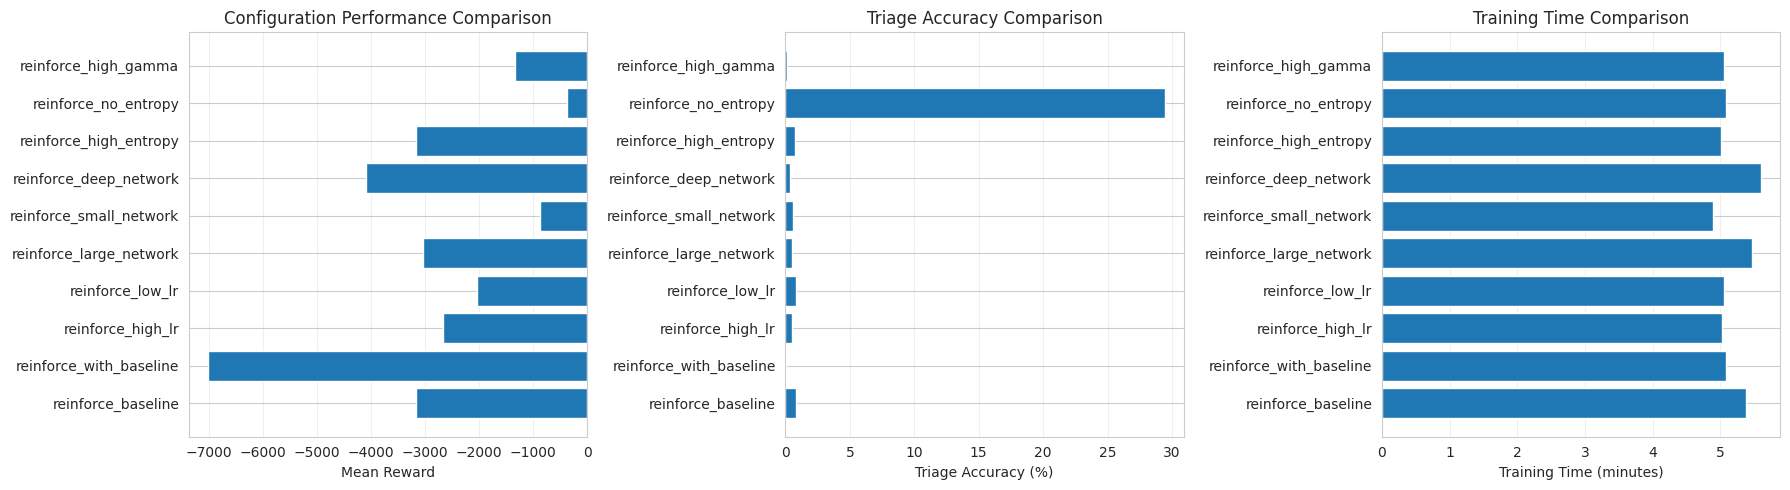


🏆 BEST CONFIGURATION: reinforce_no_entropy
   Mean Reward: -365.23
   Triage Accuracy: 29.4%

   Hyperparameters:
     learning_rate: 0.001
     gamma: 0.99
     use_baseline: False
     entropy_coef: 0.0
     hidden_dims: [128, 128]


In [ ]:
# Create results dataframe
sweep_df = pd.DataFrame(sweep_results)

# Save sweep results
sweep_csv_path = f"{PROJECT_DIR}/results/reinforce_sweep_results.csv"
save_results_to_csv(sweep_results, sweep_csv_path)

# Display sorted results
print("\n" + "="*60)
print("SWEEP RESULTS (sorted by mean reward)")
print("="*60)
print(sweep_df.sort_values('mean_reward', ascending=False)[
    ['config_id', 'mean_reward', 'triage_accuracy', 'training_time_sec']
].to_string(index=False))
print("="*60)

# Plot comparison
plot_config_comparison(
    sweep_df,
    save_path=f"{PROJECT_DIR}/plots/reinforce_sweep_comparison.png"
)

# Identify best config
best_config_id = sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'config_id']
best_config = next(c for c in configs if c['id'] == best_config_id)

print(f"\n🏆 BEST CONFIGURATION: {best_config_id}")
print(f"   Mean Reward: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'mean_reward']:.2f}")
print(f"   Triage Accuracy: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'triage_accuracy']:.1f}%")
print(f"\n   Hyperparameters:")
for key in ['learning_rate', 'gamma', 'use_baseline', 'entropy_coef', 'hidden_dims']:
    print(f"     {key}: {best_config[key]}")


## 7. Full Training: Best Config with 5 Seeds (200K steps each)

**Purpose**: Train the best configuration with multiple seeds for statistical significance.

**Runtime**: ~3-4 hours on Colab GPU


In [ ]:
# Full training with multiple seeds
print("\n" + "="*60)
print(f"FULL TRAINING: {best_config_id} with 5 seeds")
print("="*60)

full_results = []
full_models = {}
SEEDS = [42, 123, 456, 789, 1024]

for i, seed in enumerate(SEEDS):
    print(f"\n[Seed {i+1}/5] Training with seed={seed}")
    print("-" * 60)

    # Create environment
    env = ClinicEnv(seed=seed, max_steps=500)

    start_time = time.time()

    try:
        model, eval_results = train_reinforce_config(
            best_config, env,
            num_episodes=1000,
            seed=seed
        )

        elapsed = time.time() - start_time

        # Store results
        result = {
            "config_id": best_config_id,
            "seed": seed,
            "mean_reward": eval_results["mean_reward"],
            "std_reward": eval_results["std_reward"],
            "triage_accuracy": eval_results["mean_triage_accuracy"],
            "triage_accuracy_std": eval_results["std_triage_accuracy"],
            "mean_length": eval_results["mean_length"],
            "training_time_sec": elapsed
        }

        full_results.append(result)
        full_models[f"seed_{seed}"] = model

        print(f"✓ Completed in {elapsed:.1f}s")
        print(f"  Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
        print(f"  Triage Accuracy: {eval_results['mean_triage_accuracy']:.1f}% ± {eval_results['std_triage_accuracy']:.1f}%")

        # Save model to Drive
        model_path = f"{PROJECT_DIR}/models/reinforce/{best_config_id}_seed{seed}.pt"
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        model.save(model_path)
        print(f"  Model saved: {model_path}")

    except Exception as e:
        print(f"✗ Error training seed {seed}: {str(e)}")
        continue

    env.close()

print("\n" + "="*60)
print("FULL TRAINING COMPLETE!")
print("="*60)


FULL TRAINING: reinforce_no_entropy with 5 seeds

[Seed 1/5] Training with seed=42
------------------------------------------------------------
✓ Completed in 597.9s
  Mean Reward: -367.85 ± 20.06
  Triage Accuracy: 28.1% ± 1.8%
  Model saved: /content/drive/MyDrive/RL_Summative/models/reinforce/reinforce_no_entropy_seed42.pt

[Seed 2/5] Training with seed=123
------------------------------------------------------------
✓ Completed in 595.4s
  Mean Reward: -5328.96 ± 1381.32
  Triage Accuracy: 0.6% ± 0.7%
  Model saved: /content/drive/MyDrive/RL_Summative/models/reinforce/reinforce_no_entropy_seed123.pt

[Seed 3/5] Training with seed=456
------------------------------------------------------------
✓ Completed in 596.3s
  Mean Reward: -319.29 ± 23.07
  Triage Accuracy: 36.0% ± 1.6%
  Model saved: /content/drive/MyDrive/RL_Summative/models/reinforce/reinforce_no_entropy_seed456.pt

[Seed 4/5] Training with seed=789
------------------------------------------------------------
✓ Completed

## 8. Final Results & Visualization


✓ Results saved to /content/drive/MyDrive/RL_Summative/results/reinforce_full_results.csv

FINAL RESULTS (aggregated across 5 seeds)
Configuration: reinforce_no_entropy
Total Timesteps: 200,000 per seed × 5 seeds = 1,000,000

Mean Reward: -1553.88 ± 2168.93
Triage Accuracy: 21.5% ± 18.5%
Avg Episode Length: 500.0
Total Training Time: 0.83 hours

✓ Plot saved to /content/drive/MyDrive/RL_Summative/plots/reinforce_full_training.png


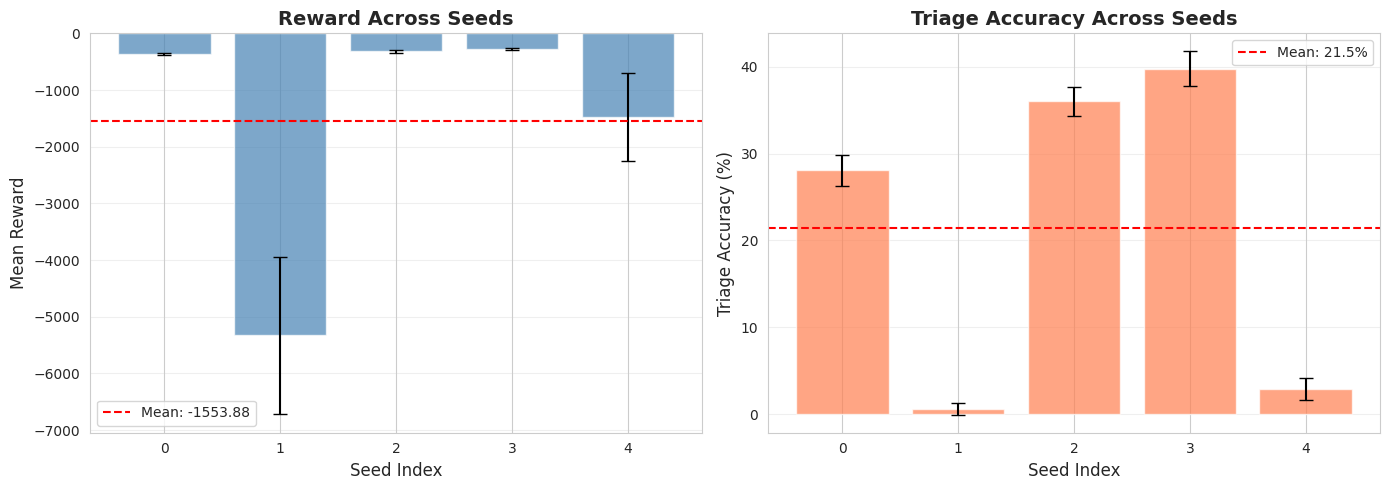

In [ ]:
# Aggregate full training results
full_df = pd.DataFrame(full_results)

# Save full results
full_csv_path = f"{PROJECT_DIR}/results/reinforce_full_results.csv"
save_results_to_csv(full_results, full_csv_path)

# Calculate statistics across seeds
print("\n" + "="*60)
print("FINAL RESULTS (aggregated across 5 seeds)")
print("="*60)
print(f"Configuration: {best_config_id}")
print(f"Total Timesteps: 200,000 per seed × 5 seeds = 1,000,000")
print()
print(f"Mean Reward: {full_df['mean_reward'].mean():.2f} ± {full_df['mean_reward'].std():.2f}")
print(f"Triage Accuracy: {full_df['triage_accuracy'].mean():.1f}% ± {full_df['triage_accuracy'].std():.1f}%")
print(f"Avg Episode Length: {full_df['mean_length'].mean():.1f}")
print(f"Total Training Time: {full_df['training_time_sec'].sum()/3600:.2f} hours")
print("="*60)

# Plot full training results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reward distribution
ax1 = axes[0]
ax1.bar(range(len(SEEDS)), full_df['mean_reward'],
        yerr=full_df['std_reward'], capsize=5, alpha=0.7, color='steelblue')
ax1.axhline(y=full_df['mean_reward'].mean(), color='red', linestyle='--',
            label=f"Mean: {full_df['mean_reward'].mean():.2f}")
ax1.set_xlabel('Seed Index', fontsize=12)
ax1.set_ylabel('Mean Reward', fontsize=12)
ax1.set_title('Reward Across Seeds', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Triage accuracy distribution
ax2 = axes[1]
ax2.bar(range(len(SEEDS)), full_df['triage_accuracy'],
        yerr=full_df['triage_accuracy_std'], capsize=5, alpha=0.7, color='coral')
ax2.axhline(y=full_df['triage_accuracy'].mean(), color='red', linestyle='--',
            label=f"Mean: {full_df['triage_accuracy'].mean():.1f}%")
ax2.set_xlabel('Seed Index', fontsize=12)
ax2.set_ylabel('Triage Accuracy (%)', fontsize=12)
ax2.set_title('Triage Accuracy Across Seeds', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
full_plot_path = f"{PROJECT_DIR}/plots/reinforce_full_training.png"
plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Plot saved to {full_plot_path}")
plt.show()


## 9. Save Best Model & Export Summary


In [ ]:
# Identify best model from full training
best_seed_idx = full_df['mean_reward'].idxmax()
best_seed = full_df.loc[best_seed_idx, 'seed']
best_model = full_models[f"seed_{best_seed}"]

# Save best model
best_model_path = f"{PROJECT_DIR}/models/reinforce/best_model.zip"
best_model.save(best_model_path)
print(f"✓ Best model saved to {best_model_path}")
print(f"  (seed={best_seed}, reward={full_df.loc[best_seed_idx, 'mean_reward']:.2f})")

# Create summary JSON
summary = {
    "algorithm": "REINFORCE",
    "best_config_id": best_config_id,
    "best_config": best_config,
    "quick_sweep": {
        "num_configs": len(configs),
        "timesteps_per_config": 50000,
        "best_mean_reward": float(sweep_df['mean_reward'].max()),
        "best_triage_accuracy": float(sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'triage_accuracy'])
    },
    "full_training": {
        "num_seeds": len(SEEDS),
        "timesteps_per_seed": 200000,
        "mean_reward": float(full_df['mean_reward'].mean()),
        "std_reward": float(full_df['mean_reward'].std()),
        "mean_triage_accuracy": float(full_df['triage_accuracy'].mean()),
        "std_triage_accuracy": float(full_df['triage_accuracy'].std()),
        "best_seed": int(best_seed),
        "best_seed_reward": float(full_df.loc[best_seed_idx, 'mean_reward'])
    },
    "best_model_path": best_model_path
}

summary_path = f"{PROJECT_DIR}/results/reinforce_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Summary saved to {summary_path}")

# Display summary
print("\n" + "="*60)
print("REINFORCE TRAINING SUMMARY")
print("="*60)
print(json.dumps(summary, indent=2))
print("="*60)


✓ Best model saved to /content/drive/MyDrive/RL_Summative/models/reinforce/best_model.zip
  (seed=789, reward=-277.63)
✓ Summary saved to /content/drive/MyDrive/RL_Summative/results/reinforce_summary.json

REINFORCE TRAINING SUMMARY
{
  "algorithm": "REINFORCE",
  "best_config_id": "reinforce_no_entropy",
  "best_config": {
    "id": "reinforce_no_entropy",
    "description": "No entropy bonus",
    "learning_rate": 0.001,
    "gamma": 0.99,
    "hidden_dims": [
      128,
      128
    ],
    "use_baseline": false,
    "max_grad_norm": 0.5,
    "entropy_coef": 0.0
  },
  "quick_sweep": {
    "num_configs": 10,
    "timesteps_per_config": 50000,
    "best_mean_reward": -365.22530000000324,
    "best_triage_accuracy": 29.419999999999998
  },
  "full_training": {
    "num_seeds": 5,
    "timesteps_per_seed": 200000,
    "mean_reward": -1553.8810190000015,
    "std_reward": 2168.931563550237,
    "mean_triage_accuracy": 21.49,
    "std_triage_accuracy": 18.489518652469027,
    "best_seed"